<a href="https://colab.research.google.com/github/carloslizarragac/FisicaComputacional1/blob/master/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Analizaremos los datos de Información Estadística Climatológica del Servico Meteorológico Nacional 
# de CONAGUA que podemos descargar del sitio:
# (https://smn.conagua.gob.mx/es/climatologia/informacion-climatologica/informacion-estadistica-climatologica) 

# Tomar la dirección URL del archivo en formato 'raw'
# url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/Guaymas26292.txt'
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/3061.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]

# Estas 3 colecciones serán nuestras Series de Tiempo (DatFrames) para el análisis
 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29804 entries, 1929-11-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  29786 non-null  float64
 1   Evap    1389 non-null   float64
 2   Tmax    29723 non-null  float64
 3   Tmin    29724 non-null  float64
 4   Año     29804 non-null  int64  
 5   Mes     29804 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.6+ MB


Definimos una función para probar la Estacionaridad de una Serie de Tiempo usando la **Prueba Aumentada de Dickey-Fuller(ADF)**

In [69]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar Deviation')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


Definimos la serie de tiempo a probar....

In [41]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2017 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2012-01', '2017-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()


,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2012-01-01,0.0,NaN,21.0,12.0,2012,Jan
2012-01-02,0.0,NaN,22.0,12.0,2012,Jan
2012-01-03,0.0,NaN,23.0,11.0,2012,Jan
2012-01-04,0.0,NaN,22.0,13.0,2012,Jan
2012-01-05,0.0,NaN,21.0,12.0,2012,Jan


In [42]:
ts_90['Tmax'].head()


Fecha
2012-01-01    21.0
2012-01-02    22.0
2012-01-03    23.0
2012-01-04    22.0
2012-01-05    21.0
Name: Tmax, dtype: float64

In [48]:
# Definimos la Serie de Tiempo a estudiar con un nobre genérico

ts_test = ts_90['Tmax'].copy()


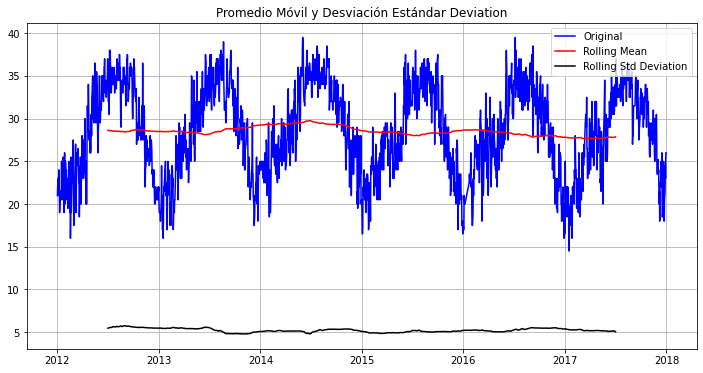

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.626671
p-value                           0.087609
#Lags Used                       16.000000
Number of Observations Used    2160.000000
Critical Value (1%)              -3.433381
Critical Value (5%)              -2.862879
Critical Value (10%)             -2.567483
dtype: float64


In [70]:
# Prueba de Etacionaridad de Tmax
test_stationarity(ts_test)



Notamos que el promedio móvil no es constante y el valor p de ADF: p > 0.05 (0.0876).

La ***tendencia*** y la ***estacionalidad*** hacen que una serie no sea estacionaria.

Primero trabajaremos para lograr que la ***Tendencia sea constante***.

Hay muchas formas para reducir la tendencia. Es hacer cambio de escalas: log(x), sqrt(x), raiz_cúbica(x),... la idea es disminuir la tendencia para valores grandes de x.




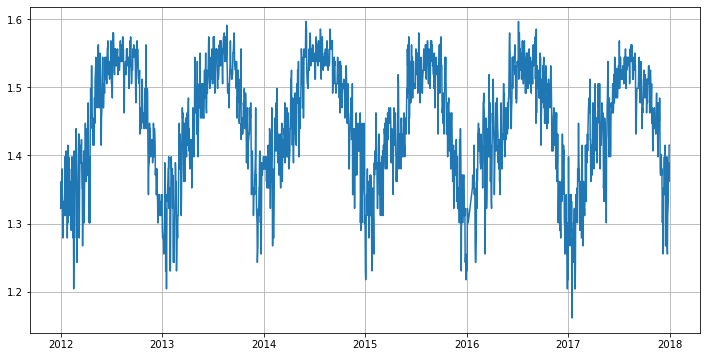

In [72]:
# Seleccionamos la función logaritmo y graficamos (La escala en y es Log Tmax)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.grid()
plt.show();


Vamos a calcular el Promedio móvil de ts_test_log con ventana de 365 y graficar para ver el contraste con la de arriba.   

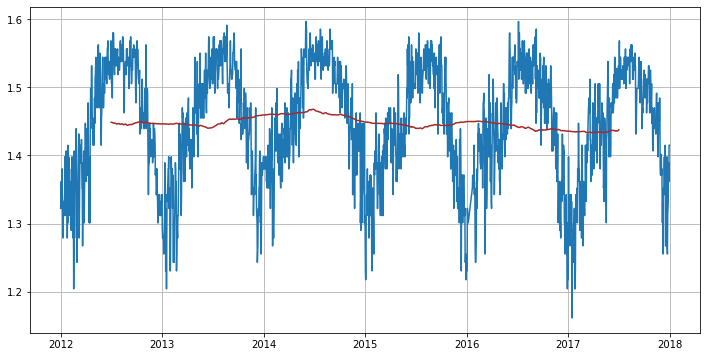

In [71]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.grid()
plt.show();


In [54]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
2012-01-01   NaN
2012-01-02   NaN
2012-01-03   NaN
2012-01-04   NaN
2012-01-05   NaN
Name: Tmax, dtype: float64

In [55]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
2012-07-01    0.095459
2012-07-02    0.056485
2012-07-03    0.056629
2012-07-04    0.056856
2012-07-05    0.036180
Name: Tmax, dtype: float64

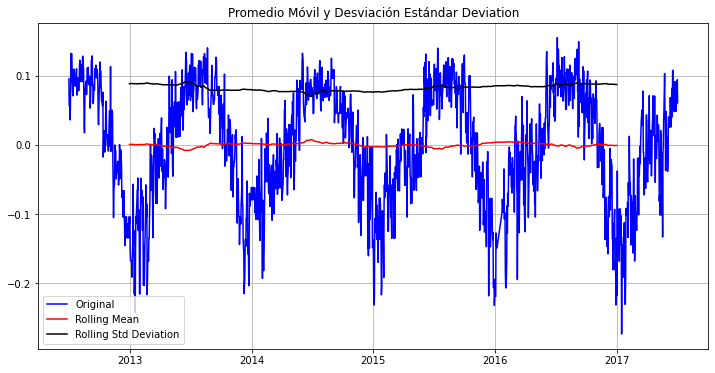

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.729849
p-value                           0.069014
#Lags Used                       13.000000
Number of Observations Used    1799.000000
Critical Value (1%)              -3.433990
Critical Value (5%)              -2.863148
Critical Value (10%)             -2.567626
dtype: float64


In [73]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)


Aún la serie de tiempo no es estacionaria. Cambiaremos el tipo de promedio móvil a Exponencial (Exponential Weighted Moving), función de pandas pd.ewm() 

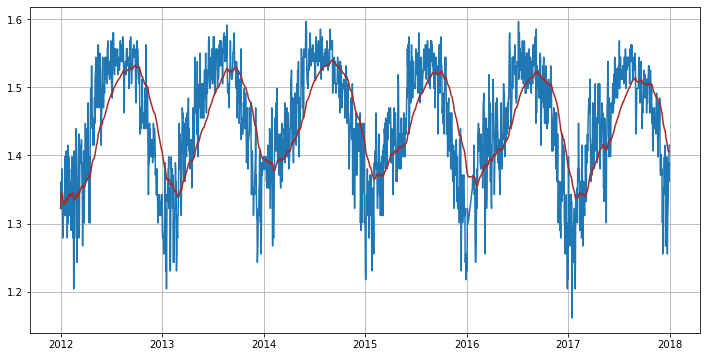

In [68]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.grid()
plt.show();


In [59]:
EWM_avg.head()

Fecha
2012-01-01    1.322219
2012-01-02    1.332331
2012-01-03    1.342148
2012-01-04    1.342217
2012-01-05    1.338202
Name: Tmax, dtype: float64

In [66]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg 


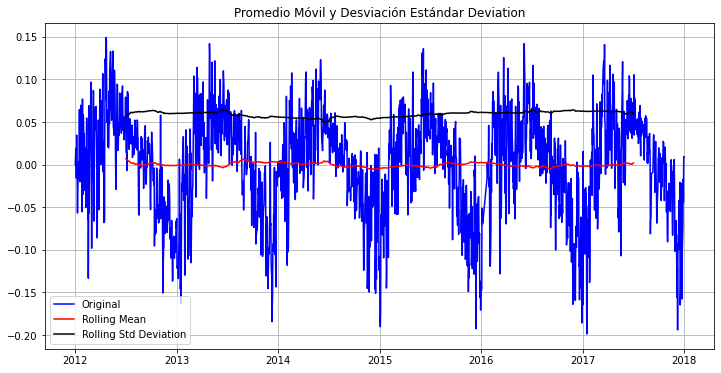

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.631610
p-value                           0.005185
#Lags Used                       16.000000
Number of Observations Used    2160.000000
Critical Value (1%)              -3.433381
Critical Value (5%)              -2.862879
Critical Value (10%)             -2.567483
dtype: float64


In [74]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)


Ahora el valor p < 0.05, es decir que podemos rechazar la hipótesis nula de que la serie de tiempo no es estacionaria y **afirmar que la serie de tiempo es estacionaria con 99% de confianza**. (Hay que jugar con el parámetro 'halflife', en este caso se usaron 30 días).

Podemos decir que **la serie es estacionaria**, pues tanto el promedio móvil exponencial y la desviación estandar son constantes. 

Ahora vamos a trabajar con la ***estacionalidad*** (variaciones debido a las estaciones del año)

Existen dos métodos para eliminar la Estacionalidad:


*   Diferenciación discreta (calcular diferencias involucrando un corrimiento 'shift()')
*   Descomposición (Tendencia + Estacionalidad + Residuo) - lo vimos en la actividad pasada. 




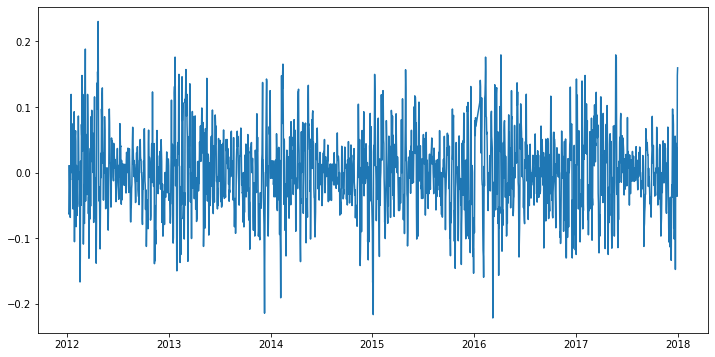

In [77]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff)


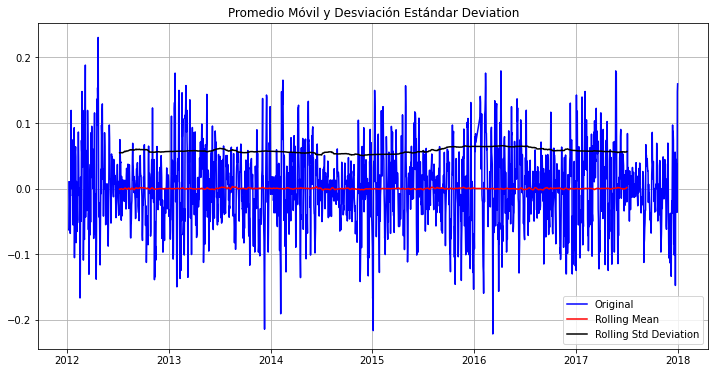

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.986665e+00
p-value                        7.070735e-15
#Lags Used                     2.600000e+01
Number of Observations Used    2.143000e+03
Critical Value (1%)           -3.433405e+00
Critical Value (5%)           -2.862890e+00
Critical Value (10%)          -2.567488e+00
dtype: float64


In [78]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)


Podemos decir que es estacionaria, el valor p < 0.05 y la desviación estándar no varía mucho.

Pero la estacionalidad domina. 

Veamos el siguiente ***método de descomposición*** que utilzamos en la actividad anterior.



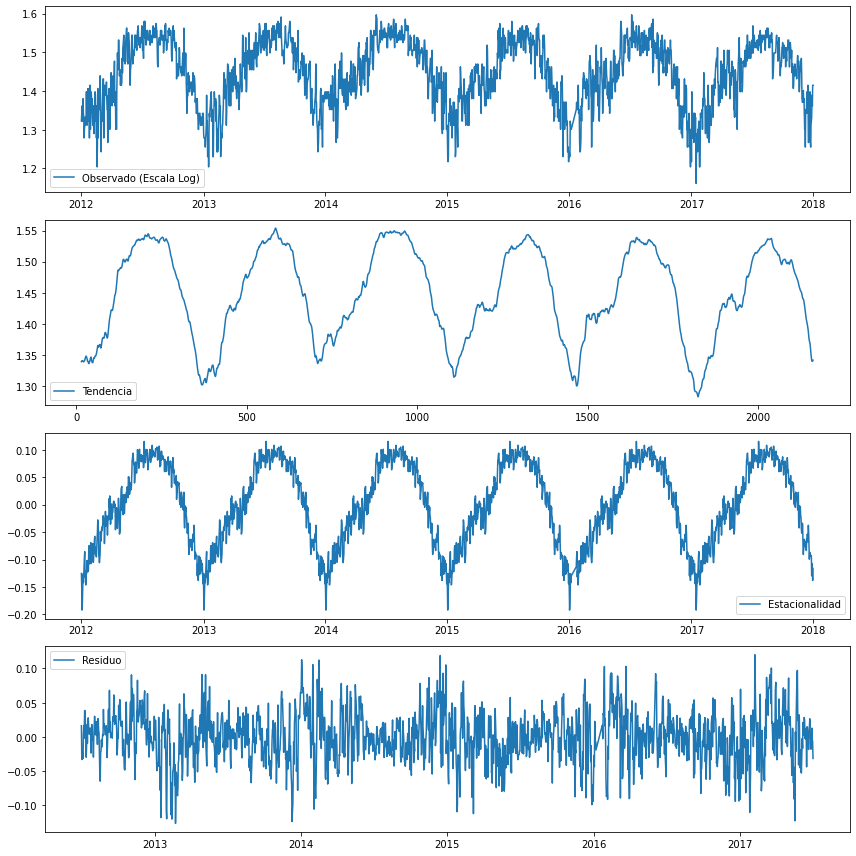

In [99]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = descomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();


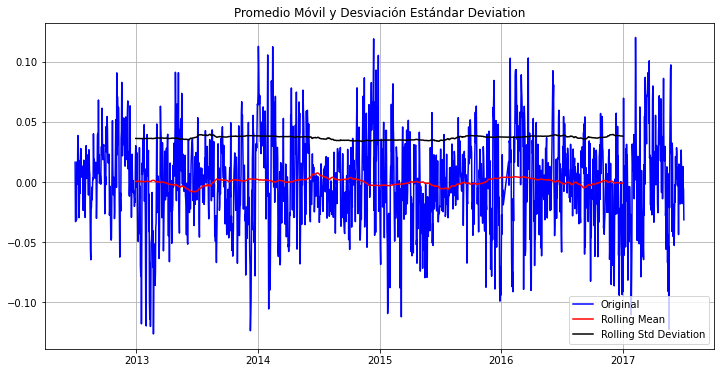

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.659549e+00
p-value                        4.864337e-14
#Lags Used                     1.300000e+01
Number of Observations Used    1.799000e+03
Critical Value (1%)           -3.433990e+00
Critical Value (5%)           -2.863148e+00
Critical Value (10%)          -2.567626e+00
dtype: float64


In [100]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)


Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (4.86 x 10^(-14)). Podemos afirmar que ***es una serie de tiempo estacionaria con mas de un 99% de confianza***. 
